Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\itn.heydar.alvaro/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\itn.heydar.alvaro/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\itn.heydar.alvaro/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\itn.heydar.alvaro/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\itn.heydar.alvaro/.insightface\models\buf

C:\Users\itn.heydar.alvaro\AppData\Roaming\Python\Python311\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[LVFace] Threshold optimal: 0.1451, Accuracy: 0.9850


C:\Users\itn.heydar.alvaro\AppData\Roaming\Python\Python311\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[INFO] Case 1 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\match\case_1
[INFO] Case 2 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\not_match\case_2
[INFO] Case 3 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\not_match\case_3
[INFO] Case 4 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\not_match\case_4
[INFO] Case 5 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\not_match\case_5
[INFO] Case 6 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\not_match\case_6
[INFO] Case 7 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\match\case_7
[INFO] Case 8 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\match\case_8
[INFO] Case 9 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\match\case_9
[INFO] Case 10 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\match\case_10
[INFO] Case 11 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\not_match\case_11
[INFO] Case 12 disimpan di: C:\Users\itn.heydar.

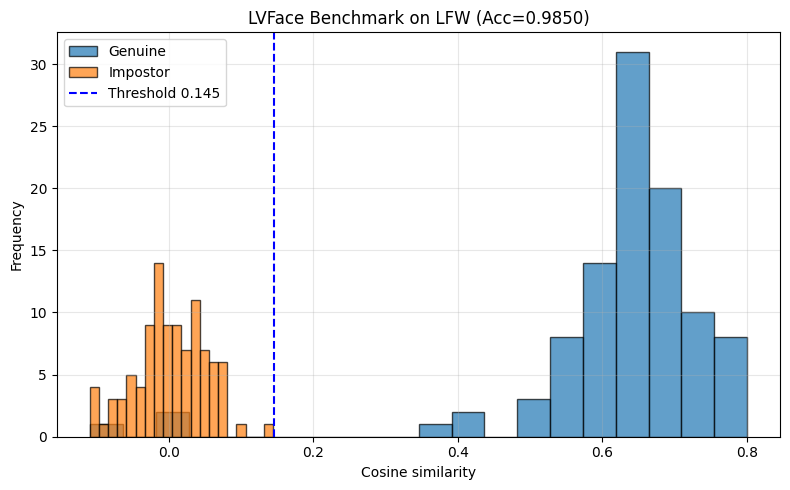

In [5]:
import os
import random
import shutil
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from skimage import transform as trans

# InsightFace
from insightface.app import FaceAnalysis
from insightface.utils import face_align

# LVFace class (pastikan file inference_onnx.py ada)
from inference_onnx import LVFaceONNXInferencer


# ======================================
# 0️⃣ Init Face Detector (SCRFD / RetinaFace via InsightFace)
# ======================================
face_app = FaceAnalysis(name="buffalo_l", providers=["CPUExecutionProvider"])
face_app.prepare(ctx_id=0, det_size=(640, 640))

# ======================================
# 1️⃣ Init LVFace Embedder
# ======================================
model_path = "LVFace-B_Glint360K.onnx"
inferencer = LVFaceONNXInferencer(model_path, use_gpu=False)


# ======================================
# 🔧 Utility Functions
# ======================================
def align_face(img, landmarks):
    """Normalize wajah dengan 5-landmarks agar sejajar ke 112x112."""
    return face_align.norm_crop(img, landmarks, image_size=112)


def augment_image(img):
    """Augmentasi sederhana untuk robust embedding."""
    h, w = img.shape[:2]
    aug_images = [img.copy()]  # original

    # Flip horizontal
    aug_images.append(cv2.flip(img, 1))

    # Grayscale + brightness
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    bright = cv2.convertScaleAbs(gray, alpha=1.2, beta=30)
    aug_images.append(bright)

    # Rotation
    angle = random.choice(range(-15, 16, 5))
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT_101)
    aug_images.append(rotated)

    # Random contrast
    alpha = random.uniform(0.8, 1.3)
    beta = random.randint(-20, 20)
    contrast = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    aug_images.append(contrast)

    return aug_images


def get_embedding_lvface(img_path, case_num, img_idx, inferencer, face_app, temp_dir="temp_aligned"):
    """Ambil embedding dengan deteksi + align + augment + average embedding."""
    os.makedirs(temp_dir, exist_ok=True)

    img = cv2.imread(img_path)
    if img is None:
        print(f"[WARN] Gagal baca gambar {img_path}")
        return None, None

    faces = face_app.get(img)
    if len(faces) == 0:
        print(f"[WARN] Tidak ada wajah terdeteksi di {img_path}")
        return None, None

    # Pilih wajah terbesar
    face = max(faces, key=lambda x: (x.bbox[2]-x.bbox[0])*(x.bbox[3]-x.bbox[1]))
    landmarks = face.kps.astype(np.float32)

    aligned = align_face(img, landmarks)
    if aligned is None:
        return None, None

    # Augmentasi
    aug_images = augment_image(aligned)

    embeddings = []
    for idx, aug in enumerate(aug_images):
        aug_path = os.path.join(temp_dir, f"case{case_num}_img{img_idx}_aug{idx}.jpg")
        cv2.imwrite(aug_path, aug)

        emb = inferencer.infer_from_image(aug_path)
        if emb is not None:
            emb = np.array(emb, dtype=np.float32).flatten()
            emb = emb / (np.linalg.norm(emb) + 1e-6)
            embeddings.append(emb)

    if len(embeddings) == 0:
        return None, None

    # Average embedding
    final_embedding = np.mean(embeddings, axis=0)
    final_embedding = final_embedding / (np.linalg.norm(final_embedding) + 1e-6)

    aligned_path = os.path.join(temp_dir, f"case{case_num}_img{img_idx}.jpg")
    cv2.imwrite(aligned_path, aligned)

    return final_embedding, aligned_path


# ======================================
# 2️⃣ Load LFW Pairs dari CSV
# ======================================
def load_lfw_pairs_from_csv(match_file, mismatch_file, base_dir,
                            genuine_limit=None, impostor_limit=None, random_seed=42):
    random.seed(random_seed)

    pairs, labels = [], []

    # --- Genuine pairs ---
    df_match = pd.read_csv(match_file)
    for _, row in df_match.iterrows():
        person = row["name"]
        img1 = os.path.join(base_dir, person, f"{person}_{int(row['imagenum1']):04d}.jpg")
        img2 = os.path.join(base_dir, person, f"{person}_{int(row['imagenum2']):04d}.jpg")
        if os.path.exists(img1) and os.path.exists(img2):
            pairs.append((img1, img2))
            labels.append(1)
        if genuine_limit and len([l for l in labels if l == 1]) >= genuine_limit:
            break

    # --- Impostor pairs ---
    df_mismatch = pd.read_csv(mismatch_file)
    for _, row in df_mismatch.iterrows():
        person1, num1, person2, num2 = row.iloc[0], row.iloc[1], row.iloc[2], row.iloc[3]
        img1 = os.path.join(base_dir, person1, f"{person1}_{int(num1):04d}.jpg")
        img2 = os.path.join(base_dir, person2, f"{person2}_{int(num2):04d}.jpg")
        if os.path.exists(img1) and os.path.exists(img2):
            pairs.append((img1, img2))
            labels.append(0)
        if impostor_limit and len([l for l in labels if l == 0]) >= impostor_limit:
            break

    # Shuffle
    combined = list(zip(pairs, labels))
    random.shuffle(combined)

    if combined:
        pairs, labels = zip(*combined)
        return list(pairs), list(labels)
    else:
        return [], []


# ======================================
# 3️⃣ Evaluasi & Simpan Hasil (DIPERBARUI: Cetak path per case)
# ======================================
def save_results_lvface_only(pairs, labels, threshold, filename, output_folder,
                             inferencer, face_app, temp_dir="temp_aligned"):
    results = []
    case_num = 1

    lvface_dir = os.path.join(output_folder, "lvface")
    os.makedirs(lvface_dir, exist_ok=True)

    for (f1, f2), label in zip(pairs, labels):
        emb1, aligned1 = get_embedding_lvface(f1, case_num, 1, inferencer, face_app, temp_dir)
        emb2, aligned2 = get_embedding_lvface(f2, case_num, 2, inferencer, face_app, temp_dir)

        if emb1 is None or emb2 is None:
            score, pred = 0.0, 0
        else:
            score = float(np.dot(emb1, emb2))
            pred = 1 if score >= threshold else 0

        results.append([case_num, label, score, pred])

        # Tentukan folder hasil per case
        result_type = "match" if pred == 1 else "not_match"
        case_dir = os.path.join(lvface_dir, result_type, f"case_{case_num}")
        os.makedirs(case_dir, exist_ok=True)

        # Simpan aligned images
        if aligned1 and os.path.exists(aligned1):
            shutil.copy(aligned1, os.path.join(case_dir, "img1.jpg"))
        if aligned2 and os.path.exists(aligned2):
            shutil.copy(aligned2, os.path.join(case_dir, "img2.jpg"))

        # Simpan info skor
        with open(os.path.join(case_dir, "score.txt"), "w") as f:
            f.write(f"true_label={label}\n")
            f.write(f"score={score:.4f}\n")
            f.write(f"pred={'MATCH' if pred == 1 else 'NOT MATCH'}\n")

        # 🔥 CETAK PATH LENGKAP FOLDER CASE INI KE KONSOL
        print(f"[INFO] Case {case_num} disimpan di: {os.path.abspath(case_dir)}")

        case_num += 1

    df = pd.DataFrame(results, columns=["case_num", "true_label", "lvface_score", "lvface_pred"])
    df.to_csv(filename, index=False)
    print(f"\n[INFO] Semua hasil disimpan di: {os.path.abspath(filename)}")
    print(f"[INFO] Folder gambar eksperimen: {os.path.abspath(lvface_dir)}")
    return df, lvface_dir


def find_optimal_threshold(scores, labels, thresholds=np.linspace(0, 1, 1000)):
    best_th, best_acc = 0.0, 0.0
    for th in thresholds:
        preds = [1 if s >= th else 0 for s in scores]
        acc = accuracy_score(labels, preds)
        if acc > best_acc:
            best_acc, best_th = acc, th
    return best_th, best_acc


# ======================================
# 🔎 MAIN
# ======================================
if __name__ == "__main__":
    base_dir = r"C:/Users/itn.heydar.alvaro/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4/lfw-deepfunneled/lfw-deepfunneled"
    match_file = r"C:/Users/itn.heydar.alvaro/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4/matchpairsDevTest.csv"
    mismatch_file = r"C:/Users/itn.heydar.alvaro/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4/mismatchpairsDevTest.csv"

    # Load pairs
    pairs, labels = load_lfw_pairs_from_csv(match_file, mismatch_file, base_dir,
                                            genuine_limit=100, impostor_limit=100)

    # Cari threshold optimal
    all_scores, valid_labels = [], []
    for case_num, ((f1, f2), label) in enumerate(zip(pairs, labels), start=1):
        emb1, _ = get_embedding_lvface(f1, case_num, 1, inferencer, face_app)
        emb2, _ = get_embedding_lvface(f2, case_num, 2, inferencer, face_app)
        if emb1 is not None and emb2 is not None:
            score = np.dot(emb1, emb2)
            all_scores.append(score)
            valid_labels.append(label)

    if all_scores:
        best_th, best_acc = find_optimal_threshold(all_scores, valid_labels)
        print(f"[LVFace] Threshold optimal: {best_th:.4f}, Accuracy: {best_acc:.4f}")
    else:
        best_th, best_acc = 0.0, 0.0

    # Simpan hasil
    output_dir = "C:/Users/itn.heydar.alvaro/Documents"
    csv_path = os.path.join(output_dir, "lvface_matching_results.csv")
    df, lvface_img_dir = save_results_lvface_only(pairs, labels, best_th, csv_path,
                                                  output_dir, inferencer, face_app)

    # Analisis distribusi skor
    genuine_scores = [s for s, l in zip(all_scores, valid_labels) if l == 1]
    impostor_scores = [s for s, l in zip(all_scores, valid_labels) if l == 0]

    if genuine_scores and impostor_scores:
        print(f"\n[DEBUG] Genuine: min={np.min(genuine_scores):.4f}, max={np.max(genuine_scores):.4f}, mean={np.mean(genuine_scores):.4f}")
        print(f"[DEBUG] Impostor: min={np.min(impostor_scores):.4f}, max={np.max(impostor_scores):.4f}, mean={np.mean(impostor_scores):.4f}")

        plt.figure(figsize=(8, 5))
        plt.hist(genuine_scores, bins=20, alpha=0.7, label="Genuine", edgecolor="black")
        plt.hist(impostor_scores, bins=20, alpha=0.7, label="Impostor", edgecolor="black")
        plt.axvline(x=best_th, color="blue", linestyle="--", label=f"Threshold {best_th:.3f}")
        plt.legend()
        plt.xlabel("Cosine similarity")
        plt.ylabel("Frequency")
        plt.title(f"LVFace Benchmark on LFW (Acc={best_acc:.4f})")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("[WARN] Tidak ada skor valid untuk genuine/impostor.")

ORIGINAL IMAGE

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\itn.heydar.alvaro/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\itn.heydar.alvaro/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\itn.heydar.alvaro/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\itn.heydar.alvaro/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\itn.heydar.alvaro/.insightface\models\buf

C:\Users\itn.heydar.alvaro\AppData\Roaming\Python\Python311\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[LVFace] Threshold optimal: 0.1221, Accuracy: 0.9850


C:\Users\itn.heydar.alvaro\AppData\Roaming\Python\Python311\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[INFO] Case 1 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\match\case_1
[INFO] Case 2 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\not_match\case_2
[INFO] Case 3 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\not_match\case_3
[INFO] Case 4 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\not_match\case_4
[INFO] Case 5 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\not_match\case_5
[INFO] Case 6 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\not_match\case_6
[INFO] Case 7 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\match\case_7
[INFO] Case 8 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\match\case_8
[INFO] Case 9 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\match\case_9
[INFO] Case 10 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\match\case_10
[INFO] Case 11 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\not_match\case_11
[INFO] Case 12 disimpan di: C:\Users\itn.heydar.

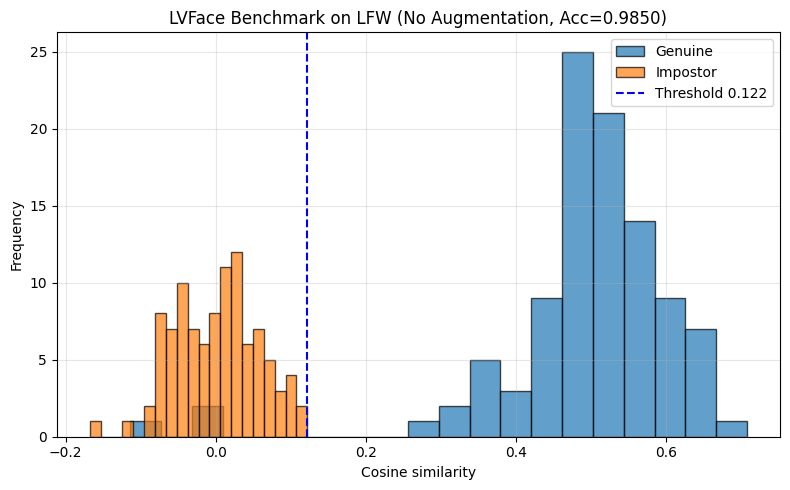

In [6]:
import os
import random
import shutil
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from insightface.app import FaceAnalysis
from insightface.utils import face_align
from inference_onnx import LVFaceONNXInferencer


# ======================================
# 0️⃣ Init Face Detector (SCRFD via InsightFace)
# ======================================
face_app = FaceAnalysis(name="buffalo_l", providers=["CPUExecutionProvider"])
face_app.prepare(ctx_id=0, det_size=(640, 640))

# ======================================
# 1️⃣ Init LVFace Embedder
# ======================================
model_path = "LVFace-B_Glint360K.onnx"
inferencer = LVFaceONNXInferencer(model_path, use_gpu=False)


# ======================================
# 🔧 Utility Functions
# ======================================
def align_face(img, landmarks):
    """Normalize wajah dengan 5-landmarks agar sejajar ke 112x112."""
    return face_align.norm_crop(img, landmarks, image_size=112)


def get_embedding_lvface(img_path, case_num, img_idx, inferencer, face_app, temp_dir="temp_aligned"):
    """Ambil embedding dari gambar aligned TANPA augmentasi."""
    os.makedirs(temp_dir, exist_ok=True)

    img = cv2.imread(img_path)
    if img is None:
        print(f"[WARN] Gagal baca gambar {img_path}")
        return None, None

    faces = face_app.get(img)
    if len(faces) == 0:
        print(f"[WARN] Tidak ada wajah terdeteksi di {img_path}")
        return None, None

    # Pilih wajah terbesar
    face = max(faces, key=lambda x: (x.bbox[2] - x.bbox[0]) * (x.bbox[3] - x.bbox[1]))
    landmarks = face.kps.astype(np.float32)

    aligned = align_face(img, landmarks)
    if aligned is None:
        return None, None

    # Simpan aligned image
    aligned_path = os.path.join(temp_dir, f"case{case_num}_img{img_idx}.jpg")
    cv2.imwrite(aligned_path, aligned)

    # Ambil embedding langsung dari gambar aligned
    emb = inferencer.infer_from_image(aligned_path)
    if emb is None:
        return None, None

    emb = np.array(emb, dtype=np.float32).flatten()
    emb = emb / (np.linalg.norm(emb) + 1e-6)  # Normalisasi L2

    return emb, aligned_path


# ======================================
# 2️⃣ Load LFW Pairs dari CSV
# ======================================
def load_lfw_pairs_from_csv(match_file, mismatch_file, base_dir,
                            genuine_limit=None, impostor_limit=None, random_seed=42):
    random.seed(random_seed)

    pairs, labels = [], []

    # --- Genuine pairs ---
    df_match = pd.read_csv(match_file)
    for _, row in df_match.iterrows():
        person = row["name"]
        img1 = os.path.join(base_dir, person, f"{person}_{int(row['imagenum1']):04d}.jpg")
        img2 = os.path.join(base_dir, person, f"{person}_{int(row['imagenum2']):04d}.jpg")
        if os.path.exists(img1) and os.path.exists(img2):
            pairs.append((img1, img2))
            labels.append(1)
        if genuine_limit and len([l for l in labels if l == 1]) >= genuine_limit:
            break

    # --- Impostor pairs ---
    df_mismatch = pd.read_csv(mismatch_file)
    for _, row in df_mismatch.iterrows():
        person1, num1, person2, num2 = row.iloc[0], row.iloc[1], row.iloc[2], row.iloc[3]
        img1 = os.path.join(base_dir, person1, f"{person1}_{int(num1):04d}.jpg")
        img2 = os.path.join(base_dir, person2, f"{person2}_{int(num2):04d}.jpg")
        if os.path.exists(img1) and os.path.exists(img2):
            pairs.append((img1, img2))
            labels.append(0)
        if impostor_limit and len([l for l in labels if l == 0]) >= impostor_limit:
            break

    # Shuffle
    combined = list(zip(pairs, labels))
    random.shuffle(combined)

    if combined:
        pairs, labels = zip(*combined)
        return list(pairs), list(labels)
    else:
        return [], []


# ======================================
# 3️⃣ Evaluasi & Simpan Hasil (DIPERBARUI: Cetak path per case)
# ======================================
def save_results_lvface_only(pairs, labels, threshold, filename, output_folder,
                             inferencer, face_app, temp_dir="temp_aligned"):
    results = []
    case_num = 1

    lvface_dir = os.path.join(output_folder, "lvface")
    os.makedirs(lvface_dir, exist_ok=True)

    for (f1, f2), label in zip(pairs, labels):
        emb1, aligned1 = get_embedding_lvface(f1, case_num, 1, inferencer, face_app, temp_dir)
        emb2, aligned2 = get_embedding_lvface(f2, case_num, 2, inferencer, face_app, temp_dir)

        if emb1 is None or emb2 is None:
            score, pred = 0.0, 0
        else:
            score = float(np.dot(emb1, emb2))  # Cosine similarity
            pred = 1 if score >= threshold else 0

        results.append([case_num, label, score, pred])

        # Tentukan folder hasil per case
        result_type = "match" if pred == 1 else "not_match"
        case_dir = os.path.join(lvface_dir, result_type, f"case_{case_num}")
        os.makedirs(case_dir, exist_ok=True)

        # Simpan aligned images
        if aligned1 and os.path.exists(aligned1):
            shutil.copy(aligned1, os.path.join(case_dir, "img1_aligned.jpg"))
        if aligned2 and os.path.exists(aligned2):
            shutil.copy(aligned2, os.path.join(case_dir, "img2_aligned.jpg"))

        # Simpan skor dan label
        with open(os.path.join(case_dir, "score.txt"), "w") as f:
            f.write(f"true_label={label}\n")
            f.write(f"score={score:.4f}\n")
            f.write(f"pred={'MATCH' if pred == 1 else 'NOT MATCH'}\n")

        # 🔥 CETAK PATH LENGKAP FOLDER CASE INI KE KONSOL
        print(f"[INFO] Case {case_num} disimpan di: {os.path.abspath(case_dir)}")

        case_num += 1

    df = pd.DataFrame(results, columns=["case_num", "true_label", "lvface_score", "lvface_pred"])
    df.to_csv(filename, index=False)
    print(f"\n[INFO] File hasil CSV disimpan di: {os.path.abspath(filename)}")
    print(f"[INFO] Semua gambar eksperimen disimpan di: {os.path.abspath(lvface_dir)}")
    return df, lvface_dir


def find_optimal_threshold(scores, labels, thresholds=np.linspace(0, 1, 1000)):
    best_th, best_acc = 0.0, 0.0
    for th in thresholds:
        preds = [1 if s >= th else 0 for s in scores]
        acc = accuracy_score(labels, preds)
        if acc > best_acc:
            best_acc, best_th = acc, th
    return best_th, best_acc


# ======================================
# 🔎 MAIN
# ======================================
if __name__ == "__main__":
    base_dir = r"C:/Users/itn.heydar.alvaro/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4/lfw-deepfunneled/lfw-deepfunneled"
    match_file = r"C:/Users/itn.heydar.alvaro/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4/matchpairsDevTest.csv"
    mismatch_file = r"C:/Users/itn.heydar.alvaro/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4/mismatchpairsDevTest.csv"

    # Load pairs
    pairs, labels = load_lfw_pairs_from_csv(match_file, mismatch_file, base_dir,
                                            genuine_limit=100, impostor_limit=100)

    # Cari threshold optimal
    all_scores, valid_labels = [], []
    for case_num, ((f1, f2), label) in enumerate(zip(pairs, labels), start=1):
        emb1, _ = get_embedding_lvface(f1, case_num, 1, inferencer, face_app)
        emb2, _ = get_embedding_lvface(f2, case_num, 2, inferencer, face_app)
        if emb1 is not None and emb2 is not None:
            score = np.dot(emb1, emb2)
            all_scores.append(score)
            valid_labels.append(label)

    if all_scores:
        best_th, best_acc = find_optimal_threshold(all_scores, valid_labels)
        print(f"[LVFace] Threshold optimal: {best_th:.4f}, Accuracy: {best_acc:.4f}")
    else:
        best_th, best_acc = 0.0, 0.0

    # Simpan hasil akhir
    output_dir = "C:/Users/itn.heydar.alvaro/Documents"
    csv_path = os.path.join(output_dir, "lvface_matching_results_no_aug.csv")
    df, lvface_img_dir = save_results_lvface_only(pairs, labels, best_th, csv_path,
                                                  output_dir, inferencer, face_app)

    # Analisis distribusi skor
    genuine_scores = [s for s, l in zip(all_scores, valid_labels) if l == 1]
    impostor_scores = [s for s, l in zip(all_scores, valid_labels) if l == 0]

    if genuine_scores and impostor_scores:
        print(f"\n[DEBUG] Genuine: min={np.min(genuine_scores):.4f}, max={np.max(genuine_scores):.4f}, mean={np.mean(genuine_scores):.4f}")
        print(f"[DEBUG] Impostor: min={np.min(impostor_scores):.4f}, max={np.max(impostor_scores):.4f}, mean={np.mean(impostor_scores):.4f}")

        plt.figure(figsize=(8, 5))
        plt.hist(genuine_scores, bins=20, alpha=0.7, label="Genuine", edgecolor="black")
        plt.hist(impostor_scores, bins=20, alpha=0.7, label="Impostor", edgecolor="black")
        plt.axvline(x=best_th, color="blue", linestyle="--", label=f"Threshold {best_th:.3f}")
        plt.legend()
        plt.xlabel("Cosine similarity")
        plt.ylabel("Frequency")
        plt.title(f"LVFace Benchmark on LFW (No Augmentation, Acc={best_acc:.4f})")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("[WARN] Tidak ada skor valid untuk genuine/impostor.")

GRAYSCALE + INCERASE BRIGTHNESS

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\itn.heydar.alvaro/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\itn.heydar.alvaro/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\itn.heydar.alvaro/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\itn.heydar.alvaro/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\itn.heydar.alvaro/.insightface\models\buf

C:\Users\itn.heydar.alvaro\AppData\Roaming\Python\Python311\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[LVFace + Grayscale+Contrast] Threshold optimal: 0.1251, Accuracy: 0.9850


C:\Users\itn.heydar.alvaro\AppData\Roaming\Python\Python311\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[INFO] Case 1 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\match\case_1
[INFO] Case 2 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\not_match\case_2
[INFO] Case 3 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\not_match\case_3
[INFO] Case 4 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\not_match\case_4
[INFO] Case 5 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\not_match\case_5
[INFO] Case 6 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\not_match\case_6
[INFO] Case 7 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\match\case_7
[INFO] Case 8 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\match\case_8
[INFO] Case 9 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\match\case_9
[INFO] Case 10 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\match\case_10
[INFO] Case 11 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\not_match\case_11
[INFO] Case 12 disimpan di: C:\Users\itn.heydar.

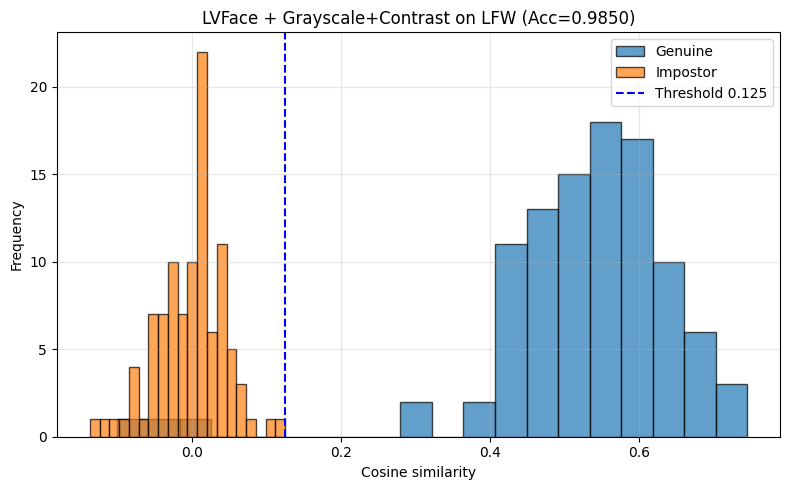

In [7]:
import os
import random
import shutil
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from insightface.app import FaceAnalysis
from insightface.utils import face_align
from inference_onnx import LVFaceONNXInferencer


# ======================================
# 0️⃣ Init Face Detector (SCRFD via InsightFace)
# ======================================
face_app = FaceAnalysis(name="buffalo_l", providers=["CPUExecutionProvider"])
face_app.prepare(ctx_id=0, det_size=(640, 640))

# ======================================
# 1️⃣ Init LVFace Embedder
# ======================================
model_path = "LVFace-B_Glint360K.onnx"
inferencer = LVFaceONNXInferencer(model_path, use_gpu=False)


# ======================================
# 🔧 Utility Functions
# ======================================
def align_face(img, landmarks):
    """Normalize wajah dengan 5-landmarks agar sejajar ke 112x112."""
    return face_align.norm_crop(img, landmarks, image_size=112)


def enhance_grayscale(img):
    """
    Konversi gambar ke grayscale, tingkatkan kontras, lalu kembalikan ke 3-channel BGR.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    enhanced = cv2.convertScaleAbs(gray, alpha=1.5, beta=0)
    enhanced_bgr = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2BGR)
    return enhanced_bgr


def get_embedding_lvface(img_path, case_num, img_idx, inferencer, face_app, temp_dir="temp_aligned"):
    """Ambil embedding dari gambar aligned yang telah diubah ke grayscale + kontras tinggi."""
    os.makedirs(temp_dir, exist_ok=True)

    img = cv2.imread(img_path)
    if img is None:
        print(f"[WARN] Gagal baca gambar {img_path}")
        return None, None

    faces = face_app.get(img)
    if len(faces) == 0:
        print(f"[WARN] Tidak ada wajah terdeteksi di {img_path}")
        return None, None

    face = max(faces, key=lambda x: (x.bbox[2] - x.bbox[0]) * (x.bbox[3] - x.bbox[1]))
    landmarks = face.kps.astype(np.float32)

    aligned = align_face(img, landmarks)
    if aligned is None:
        return None, None

    enhanced_aligned = enhance_grayscale(aligned)

    enhanced_path = os.path.join(temp_dir, f"case{case_num}_img{img_idx}_enhanced.jpg")
    cv2.imwrite(enhanced_path, enhanced_aligned)

    emb = inferencer.infer_from_image(enhanced_path)
    if emb is None:
        return None, enhanced_path

    emb = np.array(emb, dtype=np.float32).flatten()
    emb = emb / (np.linalg.norm(emb) + 1e-6)

    return emb, enhanced_path


# ======================================
# 2️⃣ Load LFW Pairs dari CSV
# ======================================
def load_lfw_pairs_from_csv(match_file, mismatch_file, base_dir,
                            genuine_limit=None, impostor_limit=None, random_seed=42):
    random.seed(random_seed)

    pairs, labels = [], []

    df_match = pd.read_csv(match_file)
    for _, row in df_match.iterrows():
        person = row["name"]
        img1 = os.path.join(base_dir, person, f"{person}_{int(row['imagenum1']):04d}.jpg")
        img2 = os.path.join(base_dir, person, f"{person}_{int(row['imagenum2']):04d}.jpg")
        if os.path.exists(img1) and os.path.exists(img2):
            pairs.append((img1, img2))
            labels.append(1)
        if genuine_limit and len([l for l in labels if l == 1]) >= genuine_limit:
            break

    df_mismatch = pd.read_csv(mismatch_file)
    for _, row in df_mismatch.iterrows():
        person1, num1, person2, num2 = row.iloc[0], row.iloc[1], row.iloc[2], row.iloc[3]
        img1 = os.path.join(base_dir, person1, f"{person1}_{int(num1):04d}.jpg")
        img2 = os.path.join(base_dir, person2, f"{person2}_{int(num2):04d}.jpg")
        if os.path.exists(img1) and os.path.exists(img2):
            pairs.append((img1, img2))
            labels.append(0)
        if impostor_limit and len([l for l in labels if l == 0]) >= impostor_limit:
            break

    combined = list(zip(pairs, labels))
    random.shuffle(combined)

    if combined:
        pairs, labels = zip(*combined)
        return list(pairs), list(labels)
    else:
        return [], []


# ======================================
# 3️⃣ Evaluasi & Simpan Hasil (DIPERBARUI: Cetak path per case)
# ======================================
def save_results_lvface_only(pairs, labels, threshold, filename, output_folder,
                             inferencer, face_app, temp_dir="temp_aligned"):
    results = []
    case_num = 1

    lvface_dir = os.path.join(output_folder, "lvface")
    os.makedirs(lvface_dir, exist_ok=True)

    for (f1, f2), label in zip(pairs, labels):
        emb1, enhanced1 = get_embedding_lvface(f1, case_num, 1, inferencer, face_app, temp_dir)
        emb2, enhanced2 = get_embedding_lvface(f2, case_num, 2, inferencer, face_app, temp_dir)

        if emb1 is None or emb2 is None:
            score, pred = 0.0, 0
        else:
            score = float(np.dot(emb1, emb2))
            pred = 1 if score >= threshold else 0

        results.append([case_num, label, score, pred])

        # Tentukan folder hasil per case
        result_type = "match" if pred == 1 else "not_match"
        case_dir = os.path.join(lvface_dir, result_type, f"case_{case_num}")
        os.makedirs(case_dir, exist_ok=True)

        # Simpan gambar enhanced
        if enhanced1 and os.path.exists(enhanced1):
            shutil.copy(enhanced1, os.path.join(case_dir, "img1_enhanced.jpg"))
        if enhanced2 and os.path.exists(enhanced2):
            shutil.copy(enhanced2, os.path.join(case_dir, "img2_enhanced.jpg"))

        # Simpan skor dan label
        with open(os.path.join(case_dir, "score.txt"), "w") as f:
            f.write(f"true_label={label}\n")
            f.write(f"score={score:.4f}\n")
            f.write(f"pred={'MATCH' if pred == 1 else 'NOT MATCH'}\n")

        # 🔥 CETAK PATH LENGKAP FOLDER CASE INI KE KONSOL
        print(f"[INFO] Case {case_num} disimpan di: {os.path.abspath(case_dir)}")

        case_num += 1

    df = pd.DataFrame(results, columns=["case_num", "true_label", "lvface_score", "lvface_pred"])
    df.to_csv(filename, index=False)
    print(f"\n[INFO] File hasil CSV disimpan di: {os.path.abspath(filename)}")
    print(f"[INFO] Semua gambar eksperimen disimpan di: {os.path.abspath(lvface_dir)}")
    return df, lvface_dir


def find_optimal_threshold(scores, labels, thresholds=np.linspace(0, 1, 1000)):
    best_th, best_acc = 0.0, 0.0
    for th in thresholds:
        preds = [1 if s >= th else 0 for s in scores]
        acc = accuracy_score(labels, preds)
        if acc > best_acc:
            best_acc, best_th = acc, th
    return best_th, best_acc


# ======================================
# 🔎 MAIN
# ======================================
if __name__ == "__main__":
    base_dir = r"C:/Users/itn.heydar.alvaro/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4/lfw-deepfunneled/lfw-deepfunneled"
    match_file = r"C:/Users/itn.heydar.alvaro/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4/matchpairsDevTest.csv"
    mismatch_file = r"C:/Users/itn.heydar.alvaro/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4/mismatchpairsDevTest.csv"

    pairs, labels = load_lfw_pairs_from_csv(match_file, mismatch_file, base_dir,
                                            genuine_limit=100, impostor_limit=100)

    all_scores, valid_labels = [], []
    for case_num, ((f1, f2), label) in enumerate(zip(pairs, labels), start=1):
        emb1, _ = get_embedding_lvface(f1, case_num, 1, inferencer, face_app)
        emb2, _ = get_embedding_lvface(f2, case_num, 2, inferencer, face_app)
        if emb1 is not None and emb2 is not None:
            score = np.dot(emb1, emb2)
            all_scores.append(score)
            valid_labels.append(label)

    if all_scores:
        best_th, best_acc = find_optimal_threshold(all_scores, valid_labels)
        print(f"[LVFace + Grayscale+Contrast] Threshold optimal: {best_th:.4f}, Accuracy: {best_acc:.4f}")
    else:
        best_th, best_acc = 0.0, 0.0

    output_dir = "C:/Users/itn.heydar.alvaro/Documents"
    csv_path = os.path.join(output_dir, "lvface_grayscale_contrast_results.csv")
    df, lvface_img_dir = save_results_lvface_only(pairs, labels, best_th, csv_path,
                                                  output_dir, inferencer, face_app)

    genuine_scores = [s for s, l in zip(all_scores, valid_labels) if l == 1]
    impostor_scores = [s for s, l in zip(all_scores, valid_labels) if l == 0]

    if genuine_scores and impostor_scores:
        print(f"\n[DEBUG] Genuine: min={np.min(genuine_scores):.4f}, max={np.max(genuine_scores):.4f}, mean={np.mean(genuine_scores):.4f}")
        print(f"[DEBUG] Impostor: min={np.min(impostor_scores):.4f}, max={np.max(impostor_scores):.4f}, mean={np.mean(impostor_scores):.4f}")

        plt.figure(figsize=(8, 5))
        plt.hist(genuine_scores, bins=20, alpha=0.7, label="Genuine", edgecolor="black")
        plt.hist(impostor_scores, bins=20, alpha=0.7, label="Impostor", edgecolor="black")
        plt.axvline(x=best_th, color="blue", linestyle="--", label=f"Threshold {best_th:.3f}")
        plt.legend()
        plt.xlabel("Cosine similarity")
        plt.ylabel("Frequency")
        plt.title(f"LVFace + Grayscale+Contrast on LFW (Acc={best_acc:.4f})")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("[WARN] Tidak ada skor valid untuk genuine/impostor.")

RGB -> BGR

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\itn.heydar.alvaro/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\itn.heydar.alvaro/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\itn.heydar.alvaro/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\itn.heydar.alvaro/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\itn.heydar.alvaro/.insightface\models\buf

C:\Users\itn.heydar.alvaro\AppData\Roaming\Python\Python311\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[LVFace + RGB→BGR] Threshold optimal: 0.1542, Accuracy: 0.9850


C:\Users\itn.heydar.alvaro\AppData\Roaming\Python\Python311\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


[INFO] Case 1 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\match\case_1
[INFO] Case 2 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\not_match\case_2
[INFO] Case 3 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\not_match\case_3
[INFO] Case 4 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\not_match\case_4
[INFO] Case 5 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\not_match\case_5
[INFO] Case 6 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\not_match\case_6
[INFO] Case 7 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\match\case_7
[INFO] Case 8 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\match\case_8
[INFO] Case 9 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\match\case_9
[INFO] Case 10 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\match\case_10
[INFO] Case 11 disimpan di: C:\Users\itn.heydar.alvaro\Documents\lvface\not_match\case_11
[INFO] Case 12 disimpan di: C:\Users\itn.heydar.

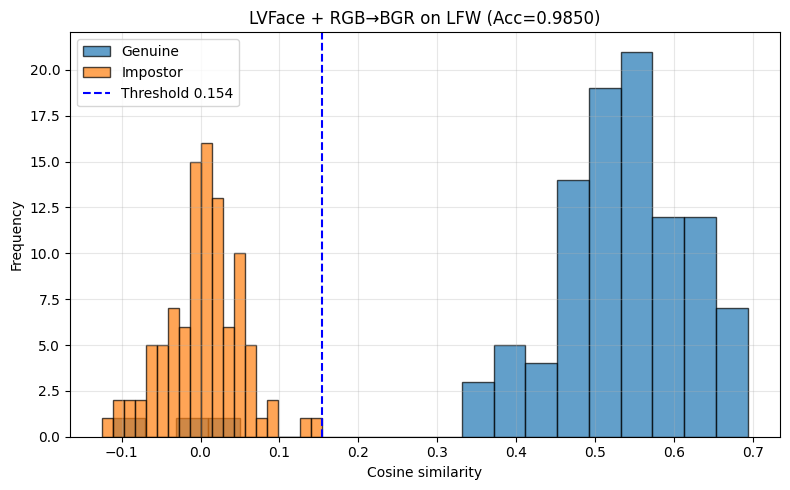

In [9]:
import os
import random
import shutil
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from insightface.app import FaceAnalysis
from insightface.utils import face_align
from inference_onnx import LVFaceONNXInferencer


# ======================================
# 0️⃣ Init Face Detector (SCRFD via InsightFace)
# ======================================
face_app = FaceAnalysis(name="buffalo_l", providers=["CPUExecutionProvider"])
face_app.prepare(ctx_id=0, det_size=(640, 640))

# ======================================
# 1️⃣ Init LVFace Embedder
# ======================================
model_path = "LVFace-B_Glint360K.onnx"
inferencer = LVFaceONNXInferencer(model_path, use_gpu=False)


# ======================================
# 🔧 Utility Functions
# ======================================
def align_face(img, landmarks):
    """Normalize wajah dengan 5-landmarks agar sejajar ke 112x112."""
    return face_align.norm_crop(img, landmarks, image_size=112)


def get_embedding_lvface(img_path, case_num, img_idx, inferencer, face_app, temp_dir="temp_aligned"):
    """Ambil embedding dari gambar aligned yang telah dikonversi dari RGB ke BGR."""
    os.makedirs(temp_dir, exist_ok=True)

    img = cv2.imread(img_path)
    if img is None:
        print(f"[WARN] Gagal baca gambar {img_path}")
        return None, None

    faces = face_app.get(img)
    if len(faces) == 0:
        print(f"[WARN] Tidak ada wajah terdeteksi di {img_path}")
        return None, None

    # Pilih wajah terbesar
    face = max(faces, key=lambda x: (x.bbox[2] - x.bbox[0]) * (x.bbox[3] - x.bbox[1]))
    landmarks = face.kps.astype(np.float32)

    aligned = align_face(img, landmarks)
    if aligned is None:
        return None, None

    # 🔥 Konversi eksplisit: asumsikan aligned adalah RGB → ubah ke BGR
    bgr_input = cv2.cvtColor(aligned, cv2.COLOR_RGB2BGR)

    # Simpan gambar BGR
    bgr_path = os.path.join(temp_dir, f"case{case_num}_img{img_idx}_bgr.jpg")
    cv2.imwrite(bgr_path, bgr_input)

    # Ambil embedding dari gambar BGR
    emb = inferencer.infer_from_image(bgr_path)
    if emb is None:
        return None, bgr_path

    emb = np.array(emb, dtype=np.float32).flatten()
    emb = emb / (np.linalg.norm(emb) + 1e-6)  # Normalisasi L2

    return emb, bgr_path


# ======================================
# 2️⃣ Load LFW Pairs dari CSV
# ======================================
def load_lfw_pairs_from_csv(match_file, mismatch_file, base_dir,
                            genuine_limit=None, impostor_limit=None, random_seed=42):
    random.seed(random_seed)

    pairs, labels = [], []

    # --- Genuine pairs ---
    df_match = pd.read_csv(match_file)
    for _, row in df_match.iterrows():
        person = row["name"]
        img1 = os.path.join(base_dir, person, f"{person}_{int(row['imagenum1']):04d}.jpg")
        img2 = os.path.join(base_dir, person, f"{person}_{int(row['imagenum2']):04d}.jpg")
        if os.path.exists(img1) and os.path.exists(img2):
            pairs.append((img1, img2))
            labels.append(1)
        if genuine_limit and len([l for l in labels if l == 1]) >= genuine_limit:
            break

    # --- Impostor pairs ---
    df_mismatch = pd.read_csv(mismatch_file)
    for _, row in df_mismatch.iterrows():
        person1, num1, person2, num2 = row.iloc[0], row.iloc[1], row.iloc[2], row.iloc[3]
        img1 = os.path.join(base_dir, person1, f"{person1}_{int(num1):04d}.jpg")
        img2 = os.path.join(base_dir, person2, f"{person2}_{int(num2):04d}.jpg")
        if os.path.exists(img1) and os.path.exists(img2):
            pairs.append((img1, img2))
            labels.append(0)
        if impostor_limit and len([l for l in labels if l == 0]) >= impostor_limit:
            break

    # Shuffle
    combined = list(zip(pairs, labels))
    random.shuffle(combined)

    if combined:
        pairs, labels = zip(*combined)
        return list(pairs), list(labels)
    else:
        return [], []


# ======================================
# 3️⃣ Evaluasi & Simpan Hasil (DIPERBARUI: Cetak path per case)
# ======================================
def save_results_lvface_only(pairs, labels, threshold, filename, output_folder,
                             inferencer, face_app, temp_dir="temp_aligned"):
    results = []
    case_num = 1

    lvface_dir = os.path.join(output_folder, "lvface")
    os.makedirs(lvface_dir, exist_ok=True)

    for (f1, f2), label in zip(pairs, labels):
        emb1, bgr1 = get_embedding_lvface(f1, case_num, 1, inferencer, face_app, temp_dir)
        emb2, bgr2 = get_embedding_lvface(f2, case_num, 2, inferencer, face_app, temp_dir)

        if emb1 is None or emb2 is None:
            score, pred = 0.0, 0
        else:
            score = float(np.dot(emb1, emb2))  # Cosine similarity
            pred = 1 if score >= threshold else 0

        results.append([case_num, label, score, pred])

        # Tentukan folder hasil per case
        result_type = "match" if pred == 1 else "not_match"
        case_dir = os.path.join(lvface_dir, result_type, f"case_{case_num}")
        os.makedirs(case_dir, exist_ok=True)

        # Simpan gambar BGR
        if bgr1 and os.path.exists(bgr1):
            shutil.copy(bgr1, os.path.join(case_dir, "img1_bgr.jpg"))
        if bgr2 and os.path.exists(bgr2):
            shutil.copy(bgr2, os.path.join(case_dir, "img2_bgr.jpg"))

        # Simpan skor dan label
        with open(os.path.join(case_dir, "score.txt"), "w") as f:
            f.write(f"true_label={label}\n")
            f.write(f"score={score:.4f}\n")
            f.write(f"pred={'MATCH' if pred == 1 else 'NOT MATCH'}\n")

        # 🔥 CETAK PATH LENGKAP FOLDER CASE INI KE KONSOL
        print(f"[INFO] Case {case_num} disimpan di: {os.path.abspath(case_dir)}")

        case_num += 1

    df = pd.DataFrame(results, columns=["case_num", "true_label", "lvface_score", "lvface_pred"])
    df.to_csv(filename, index=False)
    print(f"\n[INFO] File hasil CSV disimpan di: {os.path.abspath(filename)}")
    print(f"[INFO] Semua gambar eksperimen disimpan di: {os.path.abspath(lvface_dir)}")
    return df, lvface_dir


def find_optimal_threshold(scores, labels, thresholds=np.linspace(0, 1, 1000)):
    best_th, best_acc = 0.0, 0.0
    for th in thresholds:
        preds = [1 if s >= th else 0 for s in scores]
        acc = accuracy_score(labels, preds)
        if acc > best_acc:
            best_acc, best_th = acc, th
    return best_th, best_acc


# ======================================
# 🔎 MAIN
# ======================================
if __name__ == "__main__":
    base_dir = r"C:/Users/itn.heydar.alvaro/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4/lfw-deepfunneled/lfw-deepfunneled"
    match_file = r"C:/Users/itn.heydar.alvaro/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4/matchpairsDevTest.csv"
    mismatch_file = r"C:/Users/itn.heydar.alvaro/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4/mismatchpairsDevTest.csv"

    # Load pairs
    pairs, labels = load_lfw_pairs_from_csv(match_file, mismatch_file, base_dir,
                                            genuine_limit=100, impostor_limit=100)

    # Cari threshold optimal
    all_scores, valid_labels = [], []
    for case_num, ((f1, f2), label) in enumerate(zip(pairs, labels), start=1):
        emb1, _ = get_embedding_lvface(f1, case_num, 1, inferencer, face_app)
        emb2, _ = get_embedding_lvface(f2, case_num, 2, inferencer, face_app)
        if emb1 is not None and emb2 is not None:
            score = np.dot(emb1, emb2)
            all_scores.append(score)
            valid_labels.append(label)

    if all_scores:
        best_th, best_acc = find_optimal_threshold(all_scores, valid_labels)
        print(f"[LVFace + RGB→BGR] Threshold optimal: {best_th:.4f}, Accuracy: {best_acc:.4f}")
    else:
        best_th, best_acc = 0.0, 0.0

    # Simpan hasil akhir
    output_dir = "C:/Users/itn.heydar.alvaro/Documents"
    csv_path = os.path.join(output_dir, "lvface_rgb_to_bgr_results.csv")
    df, lvface_img_dir = save_results_lvface_only(pairs, labels, best_th, csv_path,
                                                  output_dir, inferencer, face_app)

    # Analisis distribusi skor
    genuine_scores = [s for s, l in zip(all_scores, valid_labels) if l == 1]
    impostor_scores = [s for s, l in zip(all_scores, valid_labels) if l == 0]

    if genuine_scores and impostor_scores:
        print(f"\n[DEBUG] Genuine: min={np.min(genuine_scores):.4f}, max={np.max(genuine_scores):.4f}, mean={np.mean(genuine_scores):.4f}")
        print(f"[DEBUG] Impostor: min={np.min(impostor_scores):.4f}, max={np.max(impostor_scores):.4f}, mean={np.mean(impostor_scores):.4f}")

        plt.figure(figsize=(8, 5))
        plt.hist(genuine_scores, bins=20, alpha=0.7, label="Genuine", edgecolor="black")
        plt.hist(impostor_scores, bins=20, alpha=0.7, label="Impostor", edgecolor="black")
        plt.axvline(x=best_th, color="blue", linestyle="--", label=f"Threshold {best_th:.3f}")
        plt.legend()
        plt.xlabel("Cosine similarity")
        plt.ylabel("Frequency")
        plt.title(f"LVFace + RGB→BGR on LFW (Acc={best_acc:.4f})")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("[WARN] Tidak ada skor valid untuk genuine/impostor.")

CUSTOM DATASET TESTING

[LVFace] Threshold optimal: 0.2222, Accuracy: 1.0000
[INFO] Hasil disimpan di: C:/Users/itn.heydar.alvaro/Documents\lvface_dataset_results.csv


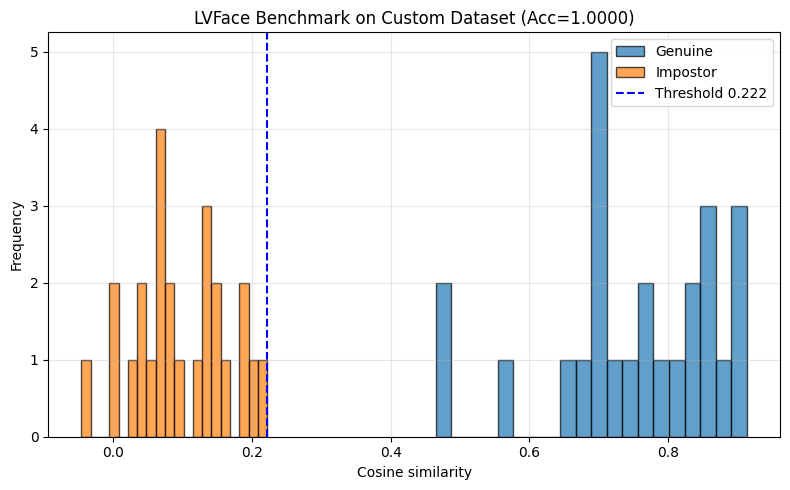

In [3]:
import os
import random
import shutil
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import torch
from facenet_pytorch import MTCNN

# LVFace class (pastikan file inference_onnx.py ada)
from inference_onnx import LVFaceONNXInferencer

# ======================================
# 0️⃣ Init Face Detector (MTCNN - PyTorch)
# ======================================
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
detector = MTCNN(keep_all=True, device=device)

# ======================================
# 1️⃣ Init LVFace Embedder
# ======================================
model_path = "LVFace-B_Glint360K.onnx"
inferencer = LVFaceONNXInferencer(model_path, use_gpu=False)


# ======================================
# 🔧 Utility Functions
# ======================================
def align_face(img, box, landmarks, image_size=112):
    """
    Align wajah berdasarkan landmark mata dari facenet-pytorch MTCNN
    """
    left_eye, right_eye = landmarks[0], landmarks[1]

    # hitung sudut rotasi berdasarkan kedua mata
    eye_center = ((left_eye[0] + right_eye[0]) / 2,
                  (left_eye[1] + right_eye[1]) / 2)
    dy = right_eye[1] - left_eye[1]
    dx = right_eye[0] - left_eye[0]
    angle = np.degrees(np.arctan2(dy, dx))

    # rotasi gambar supaya mata sejajar horizontal
    M = cv2.getRotationMatrix2D(eye_center, angle, 1)
    rotated = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

    # crop wajah sesuai bounding box setelah rotasi
    x1, y1, x2, y2 = map(int, box)
    cropped = rotated[y1:y2, x1:x2]

    # resize ke ukuran input model
    if cropped.size == 0:
        return None
    aligned = cv2.resize(cropped, (image_size, image_size))
    return aligned


def get_embedding_lvface(img_path, case_num, img_idx, inferencer, detector, temp_dir="temp_aligned"):
    os.makedirs(temp_dir, exist_ok=True)
    img = cv2.imread(img_path)
    if img is None:
        print(f"[WARN] Gagal baca gambar {img_path}")
        return None, None

    boxes, probs, landmarks = detector.detect(img, landmarks=True)
    if boxes is None or len(boxes) == 0:
        print(f"[WARN] Tidak ada wajah terdeteksi di {img_path}")
        return None, None

    # ambil wajah terbesar
    idx = np.argmax([(x2 - x1) * (y2 - y1) for (x1, y1, x2, y2) in boxes])
    box = boxes[idx]
    landmark = landmarks[idx]

    aligned = align_face(img, box, landmark, image_size=112)
    if aligned is None:
        return None, None

    aligned_path = os.path.join(temp_dir, f"case{case_num}_img{img_idx}.jpg")
    cv2.imwrite(aligned_path, aligned)

    emb = inferencer.infer_from_image(aligned_path)
    if emb is None:
        return None, None

    emb = np.array(emb, dtype=np.float32).flatten()
    emb = emb / (np.linalg.norm(emb) + 1e-6)

    return emb, aligned_path


def find_optimal_threshold(scores, labels, thresholds=np.linspace(0, 1, 1000)):
    best_th, best_acc = 0.0, 0.0
    for th in thresholds:
        preds = [1 if s >= th else 0 for s in scores]
        acc = accuracy_score(labels, preds)
        if acc > best_acc:
            best_acc, best_th = acc, th
    return best_th, best_acc


# ======================================
# 2️⃣ Buat Pairing dari Dataset
# ======================================
def make_pairs_from_dataset(base_dir, num_match=25, num_mismatch=25, random_seed=42):
    random.seed(random_seed)
    persons = [p for p in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, p))]

    pairs, labels = [], []

    # --- MATCH PAIRS ---
    while len([l for l in labels if l == 1]) < num_match:
        person = random.choice(persons)
        person_dir = os.path.join(base_dir, person)
        imgs = [os.path.join(person_dir, f) for f in os.listdir(person_dir) if f.lower().endswith((".jpg", ".png"))]
        if len(imgs) >= 2:
            i1, i2 = random.sample(imgs, 2)
            pairs.append((i1, i2))
            labels.append(1)

    # --- MISMATCH PAIRS ---
    while len([l for l in labels if l == 0]) < num_mismatch:
        p1, p2 = random.sample(persons, 2)
        imgs1 = [os.path.join(base_dir, p1, f) for f in os.listdir(os.path.join(base_dir, p1)) if f.lower().endswith((".jpg", ".png"))]
        imgs2 = [os.path.join(base_dir, p2, f) for f in os.listdir(os.path.join(base_dir, p2)) if f.lower().endswith((".jpg", ".png"))]
        if imgs1 and imgs2:
            i1, i2 = random.choice(imgs1), random.choice(imgs2)
            pairs.append((i1, i2))
            labels.append(0)

    return pairs, labels


# ======================================
# 3️⃣ Evaluasi & Simpan Hasil
# ======================================
def save_results_lvface_only(pairs, labels, threshold, filename, output_folder,
                             inferencer, detector, temp_dir="temp_aligned"):
    results = []
    case_num = 1

    lvface_dir = os.path.join(output_folder, "lvface")
    os.makedirs(lvface_dir, exist_ok=True)

    for (f1, f2), label in zip(pairs, labels):
        emb1, aligned1 = get_embedding_lvface(f1, case_num, 1, inferencer, detector, temp_dir)
        emb2, aligned2 = get_embedding_lvface(f2, case_num, 2, inferencer, detector, temp_dir)

        if emb1 is None or emb2 is None:
            score, pred = 0.0, 0
        else:
            score = float(np.dot(emb1, emb2))
            pred = 1 if score >= threshold else 0

        results.append([case_num, label, score, pred])

        # Simpan aligned face
        case_dir = os.path.join(lvface_dir, "match" if pred == 1 else "not_match", f"case_{case_num}")
        os.makedirs(case_dir, exist_ok=True)
        if aligned1: shutil.copy(aligned1, os.path.join(case_dir, "img1.jpg"))
        if aligned2: shutil.copy(aligned2, os.path.join(case_dir, "img2.jpg"))

        case_num += 1

    df = pd.DataFrame(results, columns=["case_num", "true_label", "lvface_score", "lvface_pred"])
    df.to_csv(filename, index=False)
    print(f"[INFO] Hasil disimpan di: {filename}")
    return df, lvface_dir


# ======================================
# 🔎 MAIN
# ======================================
if __name__ == "__main__":
    base_dir = r"C:/Users/itn.heydar.alvaro/LVFace/prototype-leads (3)/prototype-leads/Backend/dataset"
    output_dir = r"C:/Users/itn.heydar.alvaro/Documents"

    # Buat 25 match & 25 mismatch pairs
    pairs, labels = make_pairs_from_dataset(base_dir, num_match=25, num_mismatch=25)

    # Cari threshold optimal
    all_scores, valid_labels = [], []
    for case_num, ((f1, f2), label) in enumerate(zip(pairs, labels), start=1):
        emb1, _ = get_embedding_lvface(f1, case_num, 1, inferencer, detector)
        emb2, _ = get_embedding_lvface(f2, case_num, 2, inferencer, detector)
        if emb1 is not None and emb2 is not None:
            score = np.dot(emb1, emb2)
            all_scores.append(score)
            valid_labels.append(label)

    if all_scores:
        best_th, best_acc = find_optimal_threshold(all_scores, valid_labels)
        print(f"[LVFace] Threshold optimal: {best_th:.4f}, Accuracy: {best_acc:.4f}")
    else:
        best_th, best_acc = 0.0, 0.0

    # Simpan hasil
    csv_path = os.path.join(output_dir, "lvface_dataset_results.csv")
    df, lvface_img_dir = save_results_lvface_only(pairs, labels, best_th, csv_path,
                                                  output_dir, inferencer, detector)

    # Analisis distribusi skor
    genuine_scores = [s for s, l in zip(all_scores, valid_labels) if l == 1]
    impostor_scores = [s for s, l in zip(all_scores, valid_labels) if l == 0]

    if genuine_scores and impostor_scores:
        plt.figure(figsize=(8, 5))
        plt.hist(genuine_scores, bins=20, alpha=0.7, label="Genuine", edgecolor="black")
        plt.hist(impostor_scores, bins=20, alpha=0.7, label="Impostor", edgecolor="black")
        plt.axvline(x=best_th, color="blue", linestyle="--", label=f"Threshold {best_th:.3f}")
        plt.legend(); plt.xlabel("Cosine similarity"); plt.ylabel("Frequency")
        plt.title(f"LVFace Benchmark on Custom Dataset (Acc={best_acc:.4f})")
        plt.grid(alpha=0.3); plt.tight_layout()
        plt.show()
    else:
        print("[WARN] Tidak ada skor valid untuk genuine/impostor.")


In [4]:
import os
import random
import shutil
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from insightface.app import FaceAnalysis

from inference_onnx import LVFaceONNXInferencer  # pastikan file ini ada

# ======================================
# 0️⃣ Init Face Detector (RetinaFace via InsightFace)
# ======================================
app = FaceAnalysis(name="buffalo_l", providers=['CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))

# ======================================
# 1️⃣ Init LVFace Embedder
# ======================================
model_path = "LVFace-B_Glint360K.onnx"
inferencer = LVFaceONNXInferencer(model_path, use_gpu=False)


# ======================================
# 🔧 Utility Functions
# ======================================
def get_embedding_lvface(img_path, case_num, img_idx, inferencer, app, temp_dir="temp_aligned"):
    """
    Deteksi wajah pakai InsightFace (RetinaFace),
    crop + align otomatis (dengan padding aman), lalu dapatkan embedding LVFace.
    """
    os.makedirs(temp_dir, exist_ok=True)
    img = cv2.imread(img_path)
    if img is None:
        print(f"[WARN] Gagal baca gambar {img_path}")
        return None, None

    h, w = img.shape[:2]
    # ✅ Resize ke 640x640 agar RetinaFace bisa mendeteksi wajah kecil
    if h < 640 or w < 640:
        img = cv2.resize(img, (640, 640), interpolation=cv2.INTER_LINEAR)
        print(f"[INFO] Gambar {os.path.basename(img_path)} diresize dari {w}x{h} ke 640x640")
        h, w = img.shape[:2]

    # Deteksi wajah
    faces = app.get(img)
    if len(faces) == 0:
        print(f"[WARN] Tidak ada wajah terdeteksi di {img_path}")
        return None, None

    # Ambil wajah terbesar
    face = max(faces, key=lambda f: (f.bbox[2] - f.bbox[0]) * (f.bbox[3] - f.bbox[1]))
    bbox = face.bbox.astype(int)
    x1, y1, x2, y2 = bbox

    # ✅ Tambahkan padding agar aman dari cropping keluar batas
    pad = int(0.1 * max(x2 - x1, y2 - y1))
    x1 = max(0, x1 - pad)
    y1 = max(0, y1 - pad)
    x2 = min(w, x2 + pad)
    y2 = min(h, y2 + pad)

    cropped = img[y1:y2, x1:x2]
    if cropped.size == 0:
        print(f"[WARN] Cropped wajah kosong di {img_path}")
        return None, None

    # ✅ Pastikan ukuran hasil crop proporsional
    aligned = cv2.resize(cropped, (112, 112), interpolation=cv2.INTER_AREA)

    aligned_path = os.path.join(temp_dir, f"case{case_num}_img{img_idx}.jpg")
    cv2.imwrite(aligned_path, aligned)

    emb = inferencer.infer_from_image(aligned_path)
    if emb is None:
        print(f"[WARN] Gagal inferensi embedding di {aligned_path}")
        return None, None

    emb = np.array(emb, dtype=np.float32).flatten()
    emb = emb / (np.linalg.norm(emb) + 1e-6)
    return emb, aligned_path



# ======================================
# 2️⃣ Buat Pairing dari Dataset
# ======================================
def make_pairs_from_dataset(base_dir, num_match=25, num_mismatch=25, random_seed=42):
    random.seed(random_seed)
    persons = [p for p in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, p))]
    pairs, labels = [], []

    # MATCH PAIRS
    while len([l for l in labels if l == 1]) < num_match:
        person = random.choice(persons)
        person_dir = os.path.join(base_dir, person)
        imgs = [os.path.join(person_dir, f) for f in os.listdir(person_dir) if f.lower().endswith((".jpg", ".png"))]
        if len(imgs) >= 2:
            i1, i2 = random.sample(imgs, 2)
            pairs.append((i1, i2))
            labels.append(1)

    # MISMATCH PAIRS
    while len([l for l in labels if l == 0]) < num_mismatch:
        p1, p2 = random.sample(persons, 2)
        imgs1 = [os.path.join(base_dir, p1, f) for f in os.listdir(os.path.join(base_dir, p1)) if f.lower().endswith((".jpg", ".png"))]
        imgs2 = [os.path.join(base_dir, p2, f) for f in os.listdir(os.path.join(base_dir, p2)) if f.lower().endswith((".jpg", ".png"))]
        if imgs1 and imgs2:
            i1, i2 = random.choice(imgs1), random.choice(imgs2)
            pairs.append((i1, i2))
            labels.append(0)

    return pairs, labels


# ======================================
# 3️⃣ Evaluasi & Simpan Hasil
# ======================================
def save_results_lvface_only(pairs, labels, threshold, filename, output_folder,
                             inferencer, app, temp_dir="temp_aligned"):
    results = []
    case_num = 1

    lvface_dir = os.path.join(output_folder, "lvface")
    os.makedirs(lvface_dir, exist_ok=True)

    for (f1, f2), label in zip(pairs, labels):
        emb1, aligned1 = get_embedding_lvface(f1, case_num, 1, inferencer, app, temp_dir)
        emb2, aligned2 = get_embedding_lvface(f2, case_num, 2, inferencer, app, temp_dir)

        if emb1 is None or emb2 is None:
            score, pred = -1.0, 0
        else:
            score = float(np.dot(emb1, emb2))
            pred = 1 if score >= threshold else 0

        results.append([case_num, label, score, pred])

        case_dir = os.path.join(lvface_dir, "match" if pred == 1 else "not_match", f"case_{case_num}")
        os.makedirs(case_dir, exist_ok=True)
        if aligned1: shutil.copy(aligned1, os.path.join(case_dir, "img1.jpg"))
        if aligned2: shutil.copy(aligned2, os.path.join(case_dir, "img2.jpg"))

        case_num += 1

    df = pd.DataFrame(results, columns=["case_num", "true_label", "lvface_score", "lvface_pred"])
    df.to_csv(filename, index=False)
    print(f"[INFO] Hasil disimpan di: {filename}")
    return df, lvface_dir


# ======================================
# 🔎 MAIN
# ======================================
if __name__ == "__main__":
    base_dir = r"C:/Users/itn.heydar.alvaro/LVFace/prototype-leads (3)/prototype-leads/Backend/dataset"
    output_dir = r"C:/Users/itn.heydar.alvaro/Documents"

    pairs, labels = make_pairs_from_dataset(base_dir, num_match=25, num_mismatch=25)

    # Cari threshold optimal
    all_scores, valid_labels = [], []
    for case_num, ((f1, f2), label) in enumerate(zip(pairs, labels), start=1):
        emb1, _ = get_embedding_lvface(f1, case_num, 1, inferencer, app)
        emb2, _ = get_embedding_lvface(f2, case_num, 2, inferencer, app)
        if emb1 is not None and emb2 is not None:
            score = np.dot(emb1, emb2)
            all_scores.append(score)
            valid_labels.append(label)

    if all_scores:
        best_th, best_acc = find_optimal_threshold(all_scores, valid_labels)
        print(f"[LVFace] Threshold optimal: {best_th:.4f}, Accuracy: {best_acc:.4f}")
    else:
        best_th, best_acc = 0.0, 0.0

    csv_path = os.path.join(output_dir, "lvface_dataset_results.csv")
    df, lvface_img_dir = save_results_lvface_only(pairs, labels, best_th, csv_path,
                                                  output_dir, inferencer, app)

    # Plot distribusi
    genuine_scores = [s for s, l in zip(all_scores, valid_labels) if l == 1]
    impostor_scores = [s for s, l in zip(all_scores, valid_labels) if l == 0]

    if genuine_scores and impostor_scores:
        plt.figure(figsize=(8, 5))
        plt.hist(genuine_scores, bins=20, alpha=0.7, label="Genuine", edgecolor="black")
        plt.hist(impostor_scores, bins=20, alpha=0.7, label="Impostor", edgecolor="black")
        plt.axvline(x=best_th, color="blue", linestyle="--", label=f"Threshold {best_th:.3f}")
        plt.legend(); plt.xlabel("Cosine similarity"); plt.ylabel("Frequency")
        plt.title(f"LVFace + RetinaFace (InsightFace) Benchmark (Acc={best_acc:.4f})")
        plt.grid(alpha=0.3); plt.tight_layout()
        plt.show()
    else:
        print("[WARN] Tidak ada skor valid untuk genuine/impostor.")


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\itn.heydar.alvaro/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\itn.heydar.alvaro/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\itn.heydar.alvaro/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\itn.heydar.alvaro/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\itn.heydar.alvaro/.insightface\models\buf

EXPERIMENT HOLE

In [1]:
import os
import random
import shutil
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from skimage import transform as trans

# InsightFace
from insightface.app import FaceAnalysis
from insightface.utils import face_align

# LVFace class (pastikan file inference_onnx.py ada)
from inference_onnx import LVFaceONNXInferencer


# ======================================
# 0️⃣ Init Face Detector (SCRFD / RetinaFace via InsightFace)
# ======================================
face_app = FaceAnalysis(name="buffalo_l", providers=["CPUExecutionProvider"])
face_app.prepare(ctx_id=0, det_size=(640, 640))

# ======================================
# 1️⃣ Init LVFace Embedder
# ======================================
model_path = "LVFace-B_Glint360K.onnx"
inferencer = LVFaceONNXInferencer(model_path, use_gpu=False)


# ======================================
# 🔧 Utility Functions
# ======================================
def align_face(img, landmarks):
    """Normalize wajah dengan 5-landmarks agar sejajar ke 112x112."""
    return face_align.norm_crop(img, landmarks, image_size=112)


def augment_image(img):
    """Augmentasi sederhana untuk robust embedding."""
    h, w = img.shape[:2]
    aug_images = [img.copy()]  # original

    # Flip horizontal
    aug_images.append(cv2.flip(img, 1))

    # Grayscale + brightness
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    bright = cv2.convertScaleAbs(gray, alpha=1.2, beta=30)
    aug_images.append(bright)

    # Rotation
    angle = random.choice(range(-15, 16, 5))
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT_101)
    aug_images.append(rotated)

    # Random contrast
    alpha = random.uniform(0.8, 1.3)
    beta = random.randint(-20, 20)
    contrast = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    aug_images.append(contrast)

    return aug_images


def get_embedding_lvface(img_path, case_num, img_idx, inferencer, face_app, temp_dir="temp_aligned"):
    """Ambil embedding dengan deteksi + align + augment + average embedding."""
    os.makedirs(temp_dir, exist_ok=True)

    img = cv2.imread(img_path)
    if img is None:
        print(f"[WARN] Gagal baca gambar {img_path}")
        return None, None

    faces = face_app.get(img)
    if len(faces) == 0:
        print(f"[WARN] Tidak ada wajah terdeteksi di {img_path}")
        return None, None

    # Pilih wajah terbesar
    face = max(faces, key=lambda x: (x.bbox[2]-x.bbox[0])*(x.bbox[3]-x.bbox[1]))
    landmarks = face.kps.astype(np.float32)

    aligned = align_face(img, landmarks)
    if aligned is None:
        return None, None

    # Augmentasi
    aug_images = augment_image(aligned)

    embeddings = []
    for idx, aug in enumerate(aug_images):
        aug_path = os.path.join(temp_dir, f"case{case_num}_img{img_idx}_aug{idx}.jpg")
        cv2.imwrite(aug_path, aug)

        emb = inferencer.infer_from_image(aug_path)
        if emb is not None:
            emb = np.array(emb, dtype=np.float32).flatten()
            emb = emb / (np.linalg.norm(emb) + 1e-6)
            embeddings.append(emb)

    if len(embeddings) == 0:
        return None, None

    # Average embedding
    final_embedding = np.mean(embeddings, axis=0)
    final_embedding = final_embedding / (np.linalg.norm(final_embedding) + 1e-6)

    aligned_path = os.path.join(temp_dir, f"case{case_num}_img{img_idx}.jpg")
    cv2.imwrite(aligned_path, aligned)

    return final_embedding, aligned_path


# ======================================
# 2️⃣ Load LFW Pairs dari CSV
# ======================================
def load_lfw_pairs_from_csv(match_file, mismatch_file, base_dir,
                            genuine_limit=None, impostor_limit=None, random_seed=42):
    random.seed(random_seed)

    pairs, labels = [], []

    # --- Genuine pairs ---
    df_match = pd.read_csv(match_file)
    for _, row in df_match.iterrows():
        person = row["name"]
        img1 = os.path.join(base_dir, person, f"{person}_{int(row['imagenum1']):04d}.jpg")
        img2 = os.path.join(base_dir, person, f"{person}_{int(row['imagenum2']):04d}.jpg")
        if os.path.exists(img1) and os.path.exists(img2):
            pairs.append((img1, img2))
            labels.append(1)
        if genuine_limit and len([l for l in labels if l == 1]) >= genuine_limit:
            break

    # --- Impostor pairs ---
    df_mismatch = pd.read_csv(mismatch_file)
    for _, row in df_mismatch.iterrows():
        person1, num1, person2, num2 = row.iloc[0], row.iloc[1], row.iloc[2], row.iloc[3]
        img1 = os.path.join(base_dir, person1, f"{person1}_{int(num1):04d}.jpg")
        img2 = os.path.join(base_dir, person2, f"{person2}_{int(num2):04d}.jpg")
        if os.path.exists(img1) and os.path.exists(img2):
            pairs.append((img1, img2))
            labels.append(0)
        if impostor_limit and len([l for l in labels if l == 0]) >= impostor_limit:
            break

    # Shuffle
    combined = list(zip(pairs, labels))
    random.shuffle(combined)

    if combined:
        pairs, labels = zip(*combined)
        return list(pairs), list(labels)
    else:
        return [], []


# ======================================
# 3️⃣ Evaluasi & Simpan Hasil (DIPERBARUI: Cetak path per case)
# ======================================
def save_results_lvface_only(pairs, labels, threshold, filename, output_folder,
                             inferencer, face_app, temp_dir="temp_aligned"):
    results = []
    case_num = 1

    lvface_dir = os.path.join(output_folder, "lvface")
    os.makedirs(lvface_dir, exist_ok=True)

    for (f1, f2), label in zip(pairs, labels):
        emb1, aligned1 = get_embedding_lvface(f1, case_num, 1, inferencer, face_app, temp_dir)
        emb2, aligned2 = get_embedding_lvface(f2, case_num, 2, inferencer, face_app, temp_dir)

        if emb1 is None or emb2 is None:
            score, pred = 0.0, 0
        else:
            score = float(np.dot(emb1, emb2))
            pred = 1 if score >= threshold else 0

        results.append([case_num, label, score, pred])

        # Tentukan folder hasil per case
        result_type = "match" if pred == 1 else "not_match"
        case_dir = os.path.join(lvface_dir, result_type, f"case_{case_num}")
        os.makedirs(case_dir, exist_ok=True)

        # Simpan aligned images
        if aligned1 and os.path.exists(aligned1):
            shutil.copy(aligned1, os.path.join(case_dir, "img1.jpg"))
        if aligned2 and os.path.exists(aligned2):
            shutil.copy(aligned2, os.path.join(case_dir, "img2.jpg"))

        # Simpan info skor
        with open(os.path.join(case_dir, "score.txt"), "w") as f:
            f.write(f"true_label={label}\n")
            f.write(f"score={score:.4f}\n")
            f.write(f"pred={'MATCH' if pred == 1 else 'NOT MATCH'}\n")

        # 🔥 CETAK PATH LENGKAP FOLDER CASE INI KE KONSOL
        print(f"[INFO] Case {case_num} disimpan di: {os.path.abspath(case_dir)}")

        case_num += 1

    df = pd.DataFrame(results, columns=["case_num", "true_label", "lvface_score", "lvface_pred"])
    df.to_csv(filename, index=False)
    print(f"\n[INFO] Semua hasil disimpan di: {os.path.abspath(filename)}")
    print(f"[INFO] Folder gambar eksperimen: {os.path.abspath(lvface_dir)}")
    return df, lvface_dir


def find_optimal_threshold(scores, labels, thresholds=np.linspace(0, 1, 1000)):
    best_th, best_acc = 0.0, 0.0
    for th in thresholds:
        preds = [1 if s >= th else 0 for s in scores]
        acc = accuracy_score(labels, preds)
        if acc > best_acc:
            best_acc, best_th = acc, th
    return best_th, best_acc


# ======================================
# 🔎 MAIN
# ======================================
if __name__ == "__main__":
    base_dir = r"C:/Users/itn.heydar.alvaro/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4/lfw-deepfunneled/lfw-deepfunneled"
    match_file = r"C:/Users/itn.heydar.alvaro/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4/matchpairsDevTest.csv"
    mismatch_file = r"C:/Users/itn.heydar.alvaro/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4/mismatchpairsDevTest.csv"

    # Load pairs
    pairs, labels = load_lfw_pairs_from_csv(match_file, mismatch_file, base_dir,
                                            genuine_limit=100, impostor_limit=100)

    # Cari threshold optimal
    all_scores, valid_labels = [], []
    for case_num, ((f1, f2), label) in enumerate(zip(pairs, labels), start=1):
        emb1, _ = get_embedding_lvface(f1, case_num, 1, inferencer, face_app)
        emb2, _ = get_embedding_lvface(f2, case_num, 2, inferencer, face_app)
        if emb1 is not None and emb2 is not None:
            score = np.dot(emb1, emb2)
            all_scores.append(score)
            valid_labels.append(label)

    if all_scores:
        best_th, best_acc = find_optimal_threshold(all_scores, valid_labels)
        print(f"[LVFace] Threshold optimal: {best_th:.4f}, Accuracy: {best_acc:.4f}")
    else:
        best_th, best_acc = 0.0, 0.0

    # Simpan hasil
    output_dir = "C:/Users/itn.heydar.alvaro/Documents"
    csv_path = os.path.join(output_dir, "lvface_matching_results.csv")
    df, lvface_img_dir = save_results_lvface_only(pairs, labels, best_th, csv_path,
                                                  output_dir, inferencer, face_app)

    # Analisis distribusi skor
    genuine_scores = [s for s, l in zip(all_scores, valid_labels) if l == 1]
    impostor_scores = [s for s, l in zip(all_scores, valid_labels) if l == 0]

    if genuine_scores and impostor_scores:
        print(f"\n[DEBUG] Genuine: min={np.min(genuine_scores):.4f}, max={np.max(genuine_scores):.4f}, mean={np.mean(genuine_scores):.4f}")
        print(f"[DEBUG] Impostor: min={np.min(impostor_scores):.4f}, max={np.max(impostor_scores):.4f}, mean={np.mean(impostor_scores):.4f}")

        plt.figure(figsize=(8, 5))
        plt.hist(genuine_scores, bins=20, alpha=0.7, label="Genuine", edgecolor="black")
        plt.hist(impostor_scores, bins=20, alpha=0.7, label="Impostor", edgecolor="black")
        plt.axvline(x=best_th, color="blue", linestyle="--", label=f"Threshold {best_th:.3f}")
        plt.legend()
        plt.xlabel("Cosine similarity")
        plt.ylabel("Frequency")
        plt.title(f"LVFace Benchmark on LFW (Acc={best_acc:.4f})")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("[WARN] Tidak ada skor valid untuk genuine/impostor.")

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\itn.heydar.alvaro/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\itn.heydar.alvaro/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\itn.heydar.alvaro/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\itn.heydar.alvaro/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\itn.heydar.alvaro/.insightface\models\buf

C:\Users\itn.heydar.alvaro\AppData\Roaming\Python\Python311\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


KeyboardInterrupt: 